## ***Imports***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# sutunun genisligi
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'black', 
              'weight': 'normal', 'size': 16}
axis_font  = {'family': 'times new roman', 'color': 'black', 
              'weight': 'normal', 'size': 16}
#custom color codes
mycolors = ['#CB4335','#3498DB', '#138D75','#E67E22',
            '#E74C3C', '#5499C7', '#73C6B6', 
            '#C39BD3', '#E59866', '#16A085']
my_palette = sns.color_palette(mycolors)

plt.rcParams["font.family"] = "times new roman"
plt.rcParams["font.size"] = "14"
plt.rcParams["axes.labelweight"] = "normal"

---
### ***Analysis for different configs***

#### ***Data Preprocessing***

In [2]:
# veri setini dataframe icerisine yukle
hlf = pd.DataFrame([])
directory = 'create'
test_type = 'best_results'
payload_size = '1 KB'
conf_modes = ['message_count_10_block_size_1024', 'message_count_50_block_size_512']
test_duration=300
for conf in conf_modes:    
    for user in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
        df = pd.read_csv(directory+'/'+test_type+'/'+conf+'/'+str(user)+'_users_'+directory+'_stats.csv')
        df['users'] = user
        df[test_type] = conf
        df['payload_size'] = payload_size
        df['duration'] = test_duration
        df.drop(index=1, inplace=True)
        hlf = pd.concat([hlf, df], ignore_index=True)

hlf.drop(hlf.columns[range(11,23)], axis=1, inplace=True)
hlf.drop(columns=['Type','Average Content Size'], inplace=True)
hlf = hlf.rename(columns={'Average Response Time': 'average_latency', 
                        'Median Response Time': 'median_latency', 
                        'Min Response Time': 'min_latency', 'Max Response Time': 'max_latency',
                        'Request Count': 'request_count', 'Failure Count': 'failure_count'})

# transaction throughput = total committed transactions / total time in secs
hlf['throughput'] = (hlf['request_count']-hlf['failure_count']) / hlf['duration']
hlf['failure_ratio'] = hlf['failure_count'] / hlf['request_count'] * 100
hlf['success_count'] = hlf['request_count'] - hlf['failure_count']
hlf['success_ratio'] = hlf['success_count'] / hlf['request_count'] * 100

#### ***Plot Throughput***

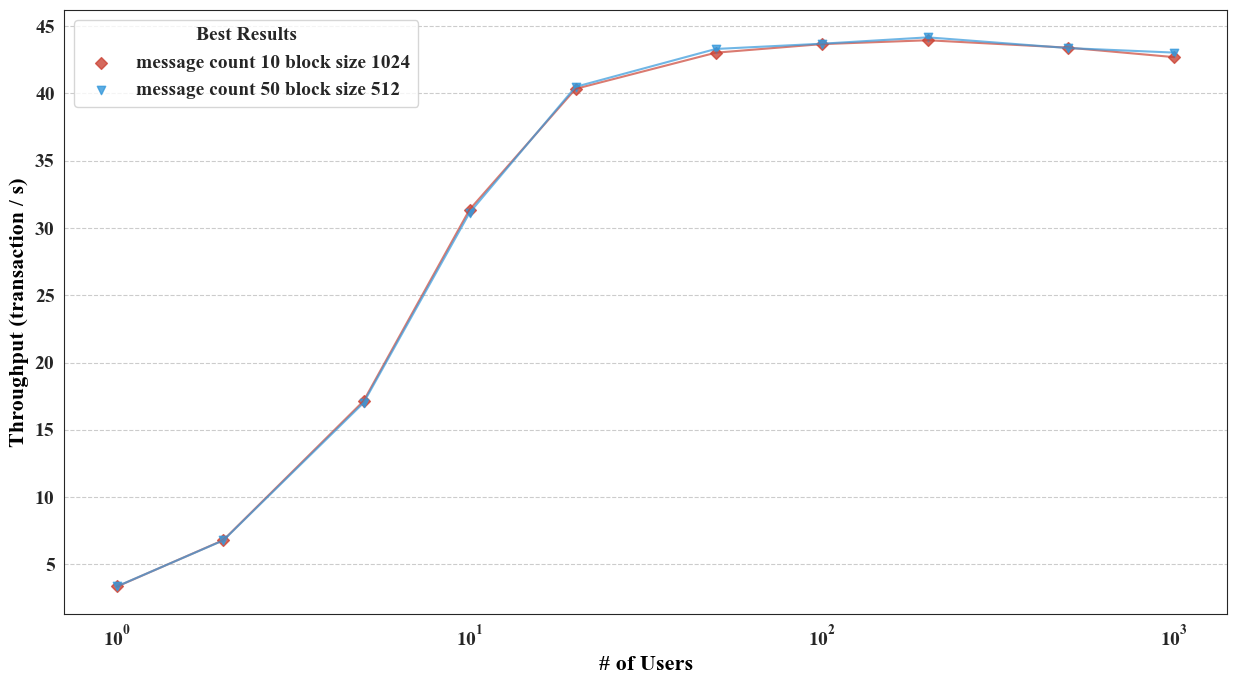

In [3]:
fig, ax0 = plt.subplots(1, 1, figsize=(15, 8),dpi=100)
markers = ['D', 'v','o','X', 'p', '>']
target_var = 'throughput'
unit = ' (transaction / s)'
unit_conf = ''
#fig, ax = plt.subplots()
for i, conf in enumerate(conf_modes):
    ax0.scatter(hlf[hlf[test_type]==conf]['users'],
                hlf[hlf[test_type]==conf][target_var], 
                marker=markers[i],
                color=mycolors[i], 
                alpha=0.8,
                #s=50,
                label=conf.replace('_',' '))
    ax0.plot(hlf[hlf[test_type]==conf]['users'],
             hlf[hlf[test_type]==conf][target_var], 
             color=mycolors[i], 
             alpha=0.7)
    ax0.set_ylabel(target_var.replace('_', ' ').title()+unit, fontdict=axis_font)
    ax0.set_xlabel('# of Users', fontdict=axis_font)
    ax0.set_xscale('log')
    ax0.legend(title=test_type.replace('_', ' ').title()+ unit_conf,loc=2)
    plt.gca().yaxis.grid(True, linestyle='--')

#plt.savefig('./images/'+directory+'_'+test_type+'_'+target_var+'.png', bbox_inches='tight')
plt.show()

#### ***Plot Latency***

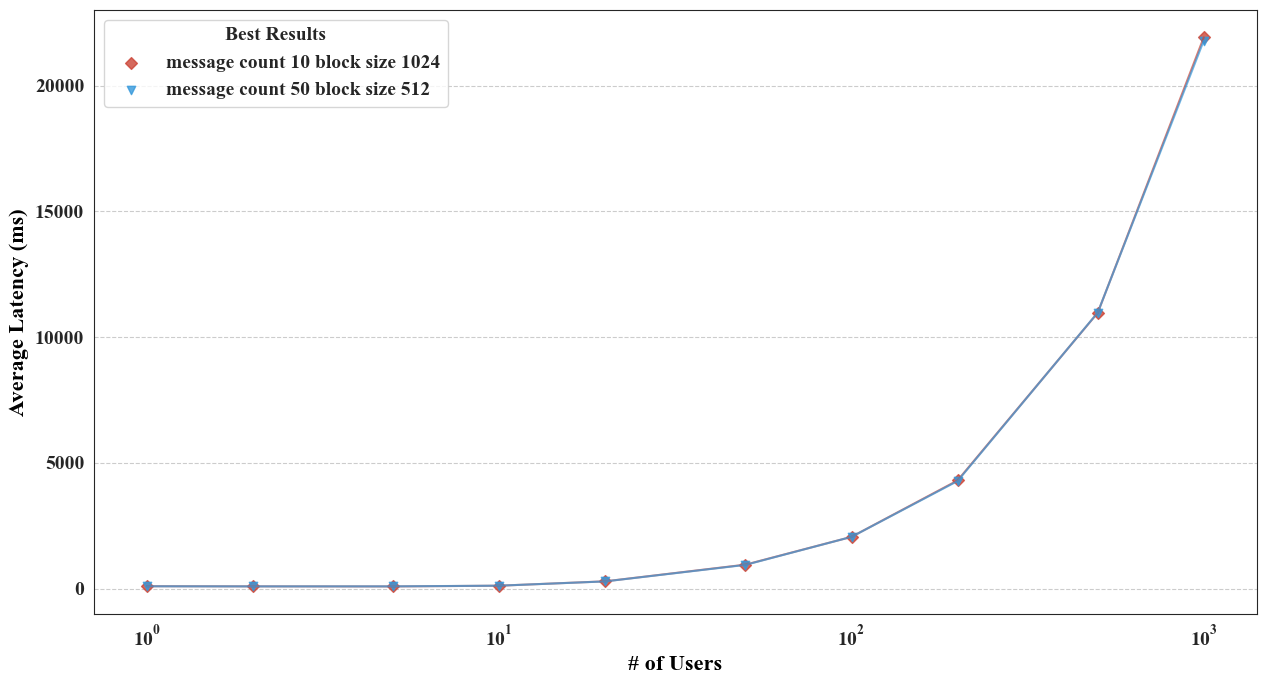

In [4]:
fig, ax0 = plt.subplots(1, 1, figsize=(15, 8),dpi=100)
markers = ['D', 'v','o','X', 'p', '>']
target_var = 'average_latency'
unit = ' (ms)'
unit_conf = ''
#fig, ax = plt.subplots()
for i, conf in enumerate(conf_modes):
    ax0.scatter(hlf[hlf[test_type]==conf]['users'],
                hlf[hlf[test_type]==conf][target_var], 
                marker=markers[i],
                color=mycolors[i], 
                alpha=0.8,
                label=conf.replace('_',' '))
    ax0.plot(hlf[hlf[test_type]==conf]['users'],
             hlf[hlf[test_type]==conf][target_var], 
             color=mycolors[i], 
             alpha=0.7)
    ax0.set_ylabel(target_var.replace('_', ' ').title()+unit, fontdict=axis_font)
    ax0.set_xlabel('# of Users', fontdict=axis_font)
    ax0.set_xscale('log')
    ax0.legend(title=test_type.replace('_', ' ').title()+ unit_conf,loc=2)
    plt.gca().yaxis.grid(True, linestyle='--')

#plt.savefig('./images/'+directory+'_'+test_type+'_'+target_var+'.png', bbox_inches='tight')
    
plt.show()

### ***Test results table***

In [5]:
test = 'Create'
metrics = ['throughput', 'average_latency']
names = ['Throughput (tps)', 'Average Latency (ms)']
unit_conf = ''
test_name = test_type.replace('_',' ').title() + unit_conf
#conf_modes = ['couchDB', 'levelDB']


print('\multirow{2}{*}{Transaction Type} & \multicolumn{2}{l}{\multirow{2}{*}{Metric}} ', end='')
print('&  \multicolumn{'+str(len(conf_modes))+'}{c}{'+test_name+'} \\\\')

cline_start=4
cline_end= cline_start+ len(conf_modes)-1
print('\cline{'+str(cline_start)+'-'+str(cline_end)+'}')

print('& &', end='')
for conf in conf_modes:
    print(' & '+ conf.replace('_',' ').title() ,end='' )
print(' \\\\')

cline_start=2
cline_end= cline_start+ len(conf_modes)+1

print('\multirow{8}{*}{'+test+'}', end=' ' )
for (metric, name) in zip(metrics,names):    
    print('& \multirow{4}{*}{'+name+'} & mean ', end='')
    for i in range (4):
        for conf in conf_modes:        
            if i==0:
                a_mean = hlf[hlf[test_type]==conf][metric].mean()
                print('& {:.1f}'.format(a_mean ), end=' ')
            elif i==1:
                a_min = hlf[hlf[test_type]==conf][metric].min()
                print('& {:.1f}'.format(a_min ), end=' ') 
            elif i==2:
                a_med = hlf[hlf[test_type]==conf][metric].median()   
                print('& {:.1f}'.format(a_med ), end=' ')
            elif i==3:
                a_max = hlf[hlf[test_type]==conf][metric].max()   
                print('& {:.1f}'.format(a_max ), end=' ')
        print('\\\\')
        if i==0:
            print('& & min ', end='')
        elif i==1:        
            print('& & median ', end='')
        elif i==2:
            print('& & max ', end='')
    if name != names[-1]:
        print('\cline{'+str(cline_start)+'-'+str(cline_end)+'}')

\multirow{2}{*}{Transaction Type} & \multicolumn{2}{l}{\multirow{2}{*}{Metric}} &  \multicolumn{2}{c}{Best Results} \\
\cline{4-5}
& & & Message Count 10 Block Size 1024 & Message Count 50 Block Size 512 \\
\multirow{8}{*}{Create} & \multirow{4}{*}{Throughput (tps)} & mean & 31.6 & 31.6 \\
& & min & 3.4 & 3.4 \\
& & median & 41.5 & 41.8 \\
& & max & 44.0 & 44.2 \\
\cline{2-5}
& \multirow{4}{*}{Average Latency (ms)} & mean & 4088.3 & 4072.7 \\
& & min & 88.0 & 90.0 \\
& & median & 622.5 & 616.5 \\
& & max & 21918.0 & 21790.0 \\
